In [1]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

In [2]:
class ProductSearchDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.data = dataset

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        row = self.data.iloc[index]

        # Extract data
        product_id = row['id']
        product_desc = row['description']
        product_cluster = row['label']

        # Get all queries
        product_queries = row[['query_1', 'query_2', 'query_3', 'query_4', 'query_5']].values

        # Randomly select one query for training
        query = np.random.choice(product_queries)

        return query, product_desc, product_id, product_cluster

In [3]:
df = pd.read_csv('pet_products_sample_queries.csv')

In [4]:
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [5]:
df.head()

,id,title,rating_number,features,description,combined_description,label,query_1,query_2,query_3,query_4,query_5
0,926,Barkbox Dog Rope Toys - Durable Tug Toys for C...,2224,['Playtime Has Never Been More Fun: Stuffed wi...,['Barkbox Rope Tug and Plush Dog Toy - Black a...,Barkbox Rope Tug and Plush Dog Toy Black and ...,0,dog toy black and blue,rope tug plush toy,beetle dog toy,interactive dog toy,durable pet toy
1,6642,Fiebing's Pure Neatsfoot Oil Leather Condition...,1605,"['Naturally replaces evaporated oils', 'Preser...","[""Fiebing's 100% Pure Neatsfoot Oil, 32 oz. - ...",Fiebings 100 Pure Neatsfoot Oil 32 oz Natural...,1,leather preservative,natural leather oil,neatsfoot oil for leather,saddle oil,leather conditioner
2,1123,"Hill's Science Diet Dry Cat Food, Adult 11+, I...",3451,['Specially formulated to fuel the energy need...,"['Product Description', ""Your may have an olde...",Product Description Your may have an older cat...,1,senior cat food,indoor cat diet,mature cat nutrition,Hill's Science Diet 11+ chicken,easy digestion cat food
3,12009,Wisdom Panel Breed Discovery Dog DNA Kit: Most...,19707,"['With the world’s most accurate pet DNA test,...","[""Know every detail of your dog's breed mix. W...",Know every detail of your dogs breed mix With ...,1,dog breed mix test,accurate breed reporting,personalized dog care,DNA test for dogs,breed identification for pets
4,3985,"MarineLand LED Aquarium Hood - 30 x 12 inch, b...",4264,"['SIZE: Fits MOST 30 inches by 12 inches.', 'D...",['Marineland brand is the world’s leading bran...,Marineland brand is the worlds leading brand o...,2,Marineland LED hood,aquarium lighting system,freshwater tank light,underwater LED effects,aquarium illumination


In [6]:
train_dataset, val_dataset = train_test_split(df, test_size=0.2, random_state=3478)
train_dataset.reset_index(drop=True, inplace=True)
val_dataset.reset_index(drop=True, inplace=True)

In [7]:
class QueryEncoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        # Use fewer transformer layers for queries since they're shorter
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=2,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)

    def forward(self, tokenizer_output):
        # Move inputs to the same device as the model
        input_ids = tokenizer_output['input_ids'].to(self.embedding_layer.weight.device)
        attention_mask = tokenizer_output['attention_mask'].to(self.embedding_layer.weight.device)

        x = self.embedding_layer(input_ids)
        x = self.encoder(x, src_key_padding_mask=attention_mask.logical_not())
        # Use mean pooling instead of CLS token for queries
        # This helps capture information from all tokens in short queries
        mask_expanded = attention_mask.unsqueeze(-1).expand(x.size())
        sum_embeddings = torch.sum(x * mask_expanded, 1)
        sum_mask = torch.sum(mask_expanded, 1)
        mean_embeddings = sum_embeddings / sum_mask
        return self.projection(mean_embeddings)

In [8]:
class ProductEncoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        # Use more transformer layers for product descriptions since they're longer
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=4,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)

    def forward(self, tokenizer_output):
        # Move inputs to the same device as the model
        input_ids = tokenizer_output['input_ids'].to(self.embedding_layer.weight.device)
        attention_mask = tokenizer_output['attention_mask'].to(self.embedding_layer.weight.device)

        x = self.embedding_layer(input_ids)
        x = self.encoder(x, src_key_padding_mask=attention_mask.logical_not())
        # Use CLS token for product descriptions
        cls_embed = x[:,0,:]
        return self.projection(cls_embed)

In [9]:
def batch_hard_negative_sampling(product_ids, cluster_ids, product_embeddings, num_negatives=1):
    """
    Sample hard negatives from the current batch, ensuring negatives come from different clusters.

    Args:
        product_ids (list): List of product IDs in the batch.
        cluster_ids (list): List of corresponding cluster IDs in the batch.
        product_embeddings (torch.Tensor): Tensor of product embeddings in the batch [batch_size, embed_dim].
        num_negatives (int): Number of negatives per query.

    Returns:
        neg_embeddings (torch.Tensor): Tensor of hard negative product embeddings [batch_size, num_negatives, embed_dim].
    """
    batch_size = len(product_ids)
    neg_samples = []

    for i in range(batch_size):
        # Get current cluster ID
        current_cluster = cluster_ids[i]

        # Find indices of products in the batch from a different cluster
        negative_indices = [j for j in range(batch_size) if cluster_ids[j] != current_cluster]

        # Sample negatives
        sampled_negatives = random.sample(negative_indices, num_negatives)

        # Store their embeddings
        neg_samples.append(product_embeddings[sampled_negatives])

    # Stack negatives into a tensor [batch_size, num_negatives, embed_dim]
    neg_embeddings = torch.stack(neg_samples).to(product_embeddings.device)

    return neg_embeddings

In [10]:
def evaluate_model(query_encoder, product_encoder, eval_dataset, tokenizer, query_max_len, product_max_len, k=10, device='cuda'):
    """
    Evaluate the model on the evaluation dataset

    Args:
        query_encoder: Query encoder model
        product_encoder: Product encoder model
        eval_dataset: Evaluation dataset
        tokenizer: Tokenizer
        query_max_len: Maximum query length
        product_max_len: Maximum product description length
        k: Number of top results to consider for metrics
        device: Device to use for computations
    """
    query_encoder.eval()
    product_encoder.eval()

    # Create evaluation dataloader
    eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=8, shuffle=False)

    # First pass: encode all products
    all_product_ids = []
    all_product_embeddings = []

    with torch.no_grad():
        for batch_data in tqdm(eval_dataloader, desc="Encoding Products"):
            _, product_descs, product_ids, _ = batch_data

            product_tokens = tokenizer(
                product_descs,
                padding=True,
                truncation=True,
                return_tensors="pt",
                max_length=product_max_len
            )

            product_embeddings = product_encoder(product_tokens)
            product_embeddings = torch.nn.functional.normalize(product_embeddings, p=2, dim=1)

            all_product_ids.extend(product_ids)
            all_product_embeddings.append(product_embeddings.cpu())  # Move to CPU to save GPU memory

    # Concatenate all product embeddings
    all_product_embeddings = torch.cat(all_product_embeddings, dim=0)

    # Second pass: evaluate queries
    total_queries = 0
    hits_at_k = 0
    mrr = 0.0  # Mean Reciprocal Rank

    with torch.no_grad():
        for batch_data in tqdm(eval_dataloader, desc="Evaluating Queries"):
            queries, _, product_ids, _ = batch_data

            query_tokens = tokenizer(
                queries,
                padding=True,
                truncation=True,
                return_tensors="pt",
                max_length=query_max_len
            )

            query_embeddings = query_encoder(query_tokens)
            query_embeddings = torch.nn.functional.normalize(query_embeddings, p=2, dim=1)

            # Move query embeddings to CPU for comparison with all products
            query_embeddings_cpu = query_embeddings.cpu()

            # Compute similarities with all products
            similarities = query_embeddings_cpu @ all_product_embeddings.T

            # Get top-k indices
            _, top_indices = torch.topk(similarities, k=k, dim=1)

            # Convert to list for evaluation
            for i, (query_id, true_product_id) in enumerate(zip(range(len(queries)), product_ids)):
                total_queries += 1
                top_k_product_ids = [all_product_ids[idx] for idx in top_indices[i].tolist()]

                # Check if true product is in top-k
                if true_product_id in top_k_product_ids:
                    hits_at_k += 1
                    # Calculate reciprocal rank
                    rank = top_k_product_ids.index(true_product_id) + 1
                    mrr += 1.0 / rank

    # Calculate metrics
    hits_at_k_rate = hits_at_k / total_queries if total_queries > 0 else 0
    mrr = mrr / total_queries if total_queries > 0 else 0

    print(f"Evaluation Metrics:")
    print(f"Hits@{k}: {hits_at_k_rate:.4f}")
    print(f"MRR: {mrr:.4f}")

    return hits_at_k_rate, mrr

In [11]:
def in_batch_negative_sampling_loss(query_embeddings, product_embeddings, negative_embeddings, temperature=0.1):
    """
    Compute in-batch negative sampling loss (InfoNCE loss) with hard negatives.

    Args:
        query_embeddings: Query embeddings [batch_size, embed_dim]
        product_embeddings: Product embeddings [batch_size, embed_dim]
        negative_embeddings: Hard negative product embeddings [batch_size, embed_dim]
        temperature: Temperature parameter for softmax.

    Returns:
        loss: InfoNCE loss
    """
    batch_size = query_embeddings.shape[0]

    # Squeeze negative embeddings to remove the unnecessary dimension
    negative_embeddings = negative_embeddings.squeeze(1)

    # Compute similarity scores
    positive_sim = (query_embeddings * product_embeddings).sum(dim=1) / temperature
    negative_sim = (query_embeddings @ negative_embeddings.T) / temperature  # Hard negatives

    # Stack positives and negatives
    logits = torch.cat([positive_sim.unsqueeze(1), negative_sim], dim=1)

    # Labels: First column (positive pair) is correct
    labels = torch.zeros(batch_size, dtype=torch.long, device=query_embeddings.device)

    # Compute loss
    loss = torch.nn.functional.cross_entropy(logits, labels)

    return loss

In [12]:
def train_embedding_model(dataset, num_epochs=10, learning_rate=1e-4, eval_dataset=None, patience=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    dataset = ProductSearchDataset(dataset)
    eval_dataset = ProductSearchDataset(eval_dataset)

    embed_size = 512
    output_embed_size = 128
    query_max_len = 32
    product_max_len = 512
    batch_size = 8

    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    # Initialize encoders
    query_encoder = QueryEncoder(vocab_size=tokenizer.vocab_size, embed_dim=embed_size, output_embed_dim=output_embed_size).to(device)
    product_encoder = ProductEncoder(vocab_size=tokenizer.vocab_size, embed_dim=embed_size, output_embed_dim=output_embed_size).to(device)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(list(query_encoder.parameters()) + list(product_encoder.parameters()), lr=learning_rate)

    scaler = torch.amp.GradScaler(device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    total_steps = len(dataloader) * num_epochs
    main_progress_bar = tqdm(total=total_steps, desc="Training Progress", position=0)

    best_hits = 0
    patience_counter = 0
    best_query_encoder_weights = None
    best_product_encoder_weights = None


    hits_log = []
    mrr_log = []

    for epoch in range(num_epochs):
        # Early stopping check
        if patience_counter == patience:
            break

        query_encoder.train()
        product_encoder.train()
        epoch_loss = []

        epoch_desc = f"Epoch {epoch+1}/{num_epochs}"
        epoch_progress = tqdm(dataloader, desc=epoch_desc, leave=False, position=1)

        for batch_idx, batch_data in enumerate(epoch_progress):
            queries, product_descs, product_ids, cluster_ids = batch_data

            query_tokens = tokenizer(queries, padding=True, truncation=True, return_tensors="pt", max_length=query_max_len).to(device)
            product_tokens = tokenizer(product_descs, padding=True, truncation=True, return_tensors="pt", max_length=product_max_len).to(device)

            with torch.amp.autocast(device.type):
                query_embeddings = query_encoder(query_tokens)
                product_embeddings = product_encoder(product_tokens)

                query_embeddings = torch.nn.functional.normalize(query_embeddings, p=2, dim=1)
                product_embeddings = torch.nn.functional.normalize(product_embeddings, p=2, dim=1)

                # Get hard negatives from the batch
                negative_embeddings = batch_hard_negative_sampling(product_ids, cluster_ids, product_embeddings, num_negatives=1)

                loss = in_batch_negative_sampling_loss(query_embeddings, product_embeddings, negative_embeddings)

            epoch_loss.append(loss.item())

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            main_progress_bar.update(1)
            epoch_progress.set_postfix({"loss": f"{loss.item():.4f}"})

        avg_loss = np.mean(epoch_loss)
        print(f"\nEpoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

        scheduler.step(avg_loss)

        if eval_dataset is not None:
            print("\nEvaluating model...")
            hits_in_top_k, mrr = evaluate_model(query_encoder, product_encoder, eval_dataset, tokenizer, query_max_len, product_max_len, device=device)
            if hits_in_top_k > best_hits:
                best_hits = hits_in_top_k
                best_query_encoder_weights = query_encoder.state_dict()
                best_product_encoder_weights = product_encoder.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
            hits_log.append(hits_in_top_k)
            mrr_log.append(mrr)

    main_progress_bar.close()

    # Load the model weights with the best validation hits
    query_encoder.load_state_dict(best_query_encoder_weights)
    product_encoder.load_state_dict(best_product_encoder_weights)

    return query_encoder, product_encoder, hits_log, mrr_log

In [13]:
query_encoder, product_encoder, hits_in_top_k_history, mrr_history = train_embedding_model(train_dataset, num_epochs=100, eval_dataset=val_dataset, patience=10)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Training Progress:   0%|          | 0/3300 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 1/100, Average Loss: 2.1970

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.1538
MRR: 0.0436


Epoch 2/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 2/100, Average Loss: 2.1587

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.1538
MRR: 0.0465


Epoch 3/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 3/100, Average Loss: 2.1551

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.1538
MRR: 0.0485


Epoch 4/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 4/100, Average Loss: 2.1589

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.2615
MRR: 0.1076


Epoch 5/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 5/100, Average Loss: 2.0495

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3231
MRR: 0.1354


Epoch 6/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 6/100, Average Loss: 1.9344

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4462
MRR: 0.1371


Epoch 7/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 7/100, Average Loss: 1.8099

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3538
MRR: 0.1178


Epoch 8/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 8/100, Average Loss: 1.7031

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3231
MRR: 0.1183


Epoch 9/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 9/100, Average Loss: 1.6738

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3692
MRR: 0.1776


Epoch 10/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 10/100, Average Loss: 1.6166

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4308
MRR: 0.1697


Epoch 11/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 11/100, Average Loss: 1.4981

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5231
MRR: 0.1831


Epoch 12/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 12/100, Average Loss: 1.5955

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4769
MRR: 0.1158


Epoch 13/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 13/100, Average Loss: 1.4835

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4923
MRR: 0.1635


Epoch 14/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 14/100, Average Loss: 1.3114

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4462
MRR: 0.1960


Epoch 15/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 15/100, Average Loss: 1.4599

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4769
MRR: 0.2089


Epoch 16/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 16/100, Average Loss: 1.2782

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5077
MRR: 0.1596


Epoch 17/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 17/100, Average Loss: 1.2252

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5846
MRR: 0.2401


Epoch 18/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 18/100, Average Loss: 1.1153

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6154
MRR: 0.2601


Epoch 19/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 19/100, Average Loss: 1.1963

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5077
MRR: 0.2061


Epoch 20/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 20/100, Average Loss: 1.2252

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4000
MRR: 0.1781


Epoch 21/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 21/100, Average Loss: 1.1321

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4923
MRR: 0.2329


Epoch 22/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 22/100, Average Loss: 1.0723

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6308
MRR: 0.3103


Epoch 23/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 23/100, Average Loss: 0.9840

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5385
MRR: 0.2269


Epoch 24/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 24/100, Average Loss: 0.8997

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6154
MRR: 0.2829


Epoch 25/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 25/100, Average Loss: 0.9179

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6154
MRR: 0.2471


Epoch 26/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 26/100, Average Loss: 0.8503

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5846
MRR: 0.2768


Epoch 27/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 27/100, Average Loss: 0.9101

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6769
MRR: 0.2968


Epoch 28/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 28/100, Average Loss: 0.8728

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6000
MRR: 0.2549


Epoch 29/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 29/100, Average Loss: 0.8261

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5385
MRR: 0.2825


Epoch 30/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 30/100, Average Loss: 0.8344

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5692
MRR: 0.2320


Epoch 31/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 31/100, Average Loss: 0.8360

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6154
MRR: 0.3467


Epoch 32/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 32/100, Average Loss: 0.7975

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6615
MRR: 0.3114


Epoch 33/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 33/100, Average Loss: 0.7893

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5385
MRR: 0.2873


Epoch 34/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 34/100, Average Loss: 0.8750

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6154
MRR: 0.2884


Epoch 35/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 35/100, Average Loss: 0.8131

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6308
MRR: 0.2971


Epoch 36/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 36/100, Average Loss: 0.7957

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6154
MRR: 0.3230


Epoch 37/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 37/100, Average Loss: 0.7903

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.7385
MRR: 0.3309


Epoch 38/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 38/100, Average Loss: 0.7991

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5692
MRR: 0.2495


Epoch 39/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 39/100, Average Loss: 0.7242

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6462
MRR: 0.2982


Epoch 40/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 40/100, Average Loss: 0.7271

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6462
MRR: 0.3419


Epoch 41/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 41/100, Average Loss: 0.7276

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6462
MRR: 0.2735


Epoch 42/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 42/100, Average Loss: 0.7197

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5846
MRR: 0.3136


Epoch 43/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 43/100, Average Loss: 0.7409

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6615
MRR: 0.3175


Epoch 44/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 44/100, Average Loss: 0.7446

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6769
MRR: 0.3539


Epoch 45/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 45/100, Average Loss: 0.7351

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6308
MRR: 0.2782


Epoch 46/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 46/100, Average Loss: 0.7304

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6462
MRR: 0.2437


Epoch 47/100:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 47/100, Average Loss: 0.7410

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6308
MRR: 0.2566


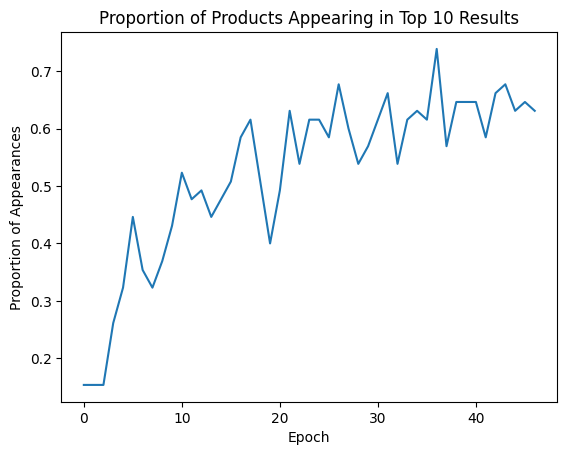

In [14]:
plt.plot(hits_in_top_k_history)
plt.xlabel("Epoch")
plt.ylabel("Proportion of Appearances")
plt.title("Proportion of Products Appearing in Top 10 Results")
plt.show()

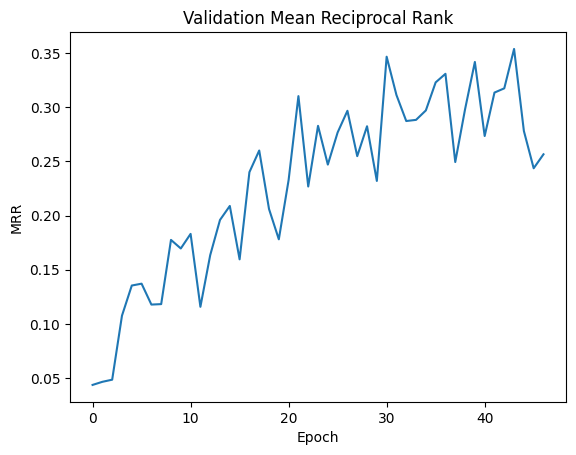

In [15]:
plt.plot(mrr_history)
plt.xlabel("Epoch")
plt.ylabel("MRR")
plt.title("Validation Mean Reciprocal Rank")
plt.show()

In [16]:
# Save models
torch.save(query_encoder.state_dict(), 'pet_products_query_encoder_v3.pt')
torch.save(product_encoder.state_dict(), 'pet_products_description_encoder_v3.pt')